In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

import sys
import os
plt.style.use('../styles/general.mplstyle')

In [2]:
import pypoptim
from pypoptim.losses import RMSE

In [3]:
sys.path.append('../pypoptim/mpi_scripts/')

from loss_utils import calculate_loss
from io_utils import collect_results
from gene_utils import update_C_from_genes


In [4]:
def show_fig(datas, 
             name = None, 
             *,
             dt = 5e-5,
             nrows = 4, 
             ncols = 5,
             color_reference="0.2",
             ls_reference="-",
             lss = None,
             lw_reference = 3,
             lws = None,
             colors = None,
             xlim = None, 
             ylim = None,
             n_sections = 20,
             all_len = 100000,
             start = -80, 
             step = 5,
             i_global = 0,
             i_global_step =1,
             ):
    
    if colors is None:
        colors = [color_reference] + [f'C{i}' for i in range(len(datas) - 1)]
    else:
        colors = [color_reference] + colors
    
    if lss is None:
        lss = [ls_reference] + ['-' for i in range(len(datas) -1)]
    else:
        lss = [ls_reference] + lss
        
    if lws is None:
        lws = [lw_reference] + [2 for i in range(len(datas) -1)]
    else:
        lws = [lw_reference] + lws
    
    
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 1.5,
                             sharex=True)
    fig.suptitle(name)
    
    len_trace = int(all_len/n_sections)
    split_indices = np.linspace(0, all_len, n_sections + 1).astype(int)
    
    t = np.arange(len_trace) * dt
    
    if xlim is None:
        xlim = (0.,len_trace * dt )
 

        
    for i_row in range(nrows):
        for i_col in range(ncols):
            ax = axes[i_row, i_col]
            plt.sca(ax)
            i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
            slice_current = slice(i_start, i_end)
            
            for k, data in enumerate(datas):
                data_show = data[slice_current]
                index_reference = 0
                data_reference = datas[0][slice_current]
                
                loss = RMSE(data_show, data_reference)
                plt.text(1, 1 - k * 0.05, f"{loss:.2f}", fontsize="x-small",
                         transform=ax.transAxes, ha="right", color=colors[k])
                
                plt.plot(t, data_show, color=colors[k], ls = lss[k], lw = lws[k])
                if ylim is None:
                    plt.ylim(min(data_show)-100, max(data_show)+50)
                else:
                    plt.ylim(ylim)
            
            step_value = start + step * i_global
            title = f'step {step_value} mV'
            plt.title(title)
            plt.xlim(xlim)
            i_global += i_global_step
            if i_col == 0:
                plt.ylabel('I, pA')
            if i_row == nrows-1:
                plt.xlabel('t, s')
                      

In [5]:
def return_phenotypes(m_dirname, m_dirs):
    phenotypes = []
    sols = []
    losses = []
    configs = []
    keyword = 'trace'
    dir_names = []
    case_names = []
    for dirname in m_dirs:
        dirname_results = os.path.normpath(os.path.join(m_dirname, dirname)) 
        cases = os.listdir(dirname_results)
        for case in cases:
            result = collect_results(case, dirname_results, dump_keys=['best', 'dump'])
            sol_best = result['sol_best'].copy()
            phenotype_best = result['phenotype_best'].copy()
            phenotypes.append(phenotype_best[keyword].I_out)
            sols.append(sol_best)
            config = result['config'].copy()
            configs.append(config)
            dir_names.append(dirname)
            case_names.append(case)

    mi = pd.MultiIndex.from_arrays([dir_names, case_names])
    phenotypes = pd.DataFrame(np.array(phenotypes).T, columns=mi)
    return {
        "phenotypes":phenotypes, 
            "sols":sols,
            "configs":configs, 
            "mi":mi}

In [6]:
m1_dirname = '../results/M1_ileak_true_01_i_in/'
m1_dirs = os.listdir(m1_dirname)
m1 = return_phenotypes(m1_dirname, m1_dirs)
m1_dirs

['2020_12_19_0035', '2020_12_19_0039']

In [7]:
real_dir = '../data/real/activation/'
real_datas = []
datas_names = os.listdir(real_dir)
names = []
for name in datas_names:
    fullpath_name = os.path.normpath(os.path.join(real_dir, name))
    real_datas.append(pd.read_csv(fullpath_name).I_out)
    names.append(name[:-4])
real_datas = pd.DataFrame(np.array(real_datas).T, columns=names)

In [8]:
real_datas

,2020_12_22_0006,2020_12_19_0034,2020_12_16_0018,2020_12_21_0007,2020_12_19_0039,2020_12_19_0035,2020_12_22_0032,2020_12_23_0007,2020_12_26_0000,2020_12_26_0014
0,-2.13623,2.13623,-10.6812,-37.2314,2.44141,-52.7954,-2.13623,2.74658,-14.9536,-1.2207
1,-15.86910,-11.59670,-23.8037,-36.6211,-10.68120,-53.1006,-14.03810,-10.07080,-14.3433,-12.8174
2,-145.26400,-135.19300,-143.1270,-36.6211,-129.08900,-52.7954,-109.55800,-127.86900,-14.3433,-134.8880
3,-380.85900,-370.17800,-246.8870,-36.6211,-319.82400,-53.1006,-284.11900,-357.66600,-14.3433,-394.5920
4,-634.15500,-639.95400,-244.7510,-36.3159,-507.20200,-53.1006,-477.90500,-619.50700,-14.0381,-704.6510
...,...,...,...,...,...,...,...,...,...,...
99995,-64.69730,-40.89360,-249.9390,-100.7080,-36.01070,-49.7437,-84.22850,-42.41940,-257.8740,-66.5283
99996,-65.00240,-40.28320,-249.3290,-100.7080,-36.62110,-49.1333,-83.92330,-43.02980,-257.8740,-66.8335
99997,-64.39210,-40.58840,-248.7180,-100.7080,-36.01070,-49.1333,-83.92330,-42.41940,-257.2630,-66.8335
99998,-64.69730,-40.28320,-248.4130,-101.0130,-36.31590,-49.1333,-83.92330,-42.11430,-256.6530,-66.8335


In [9]:
sys.path.append('../pypoptim/mpi_scripts/')
from ina_model import InaModel
from solmodel import SolModel

dirname = '../src/model_ctypes/M1/'
filename_so = os.path.join(dirname, 'ina.so')

filename_so_abs = os.path.abspath(filename_so)
Ina = InaModel(filename_so_abs)

In [10]:
legend_constants = pd.read_csv(os.path.join(dirname, "legend_test.csv"), index_col='name')['value'] 
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value'] 
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value'] 

S = legend_states.copy()
C = legend_constants.copy()
A = legend_algebraic.copy()

In [11]:
df_protocol = pd.read_csv('../data/protocols/protocol_trace.csv')
df_initial_state_protocol = pd.read_csv('../data/protocols/protocol_initial_state.csv')

In [12]:
genes = m1['sols'][0]
config = m1['configs'][0]

In [13]:
C1 = config['runtime']['legend']['constants']
C = C1.copy()
update_C_from_genes(C, genes, "trace", config)

In [14]:
I, I_a = Ina.run(A,S,C,df_protocol, df_initial_state_protocol, 20, return_algebraic=True)
I

name,v_comp,v_p,v_m,m,h,j,I_out
0,-80.0,-79.390172,-81.339441,0.000001,0.501225,0.501247,-37.695581
1,-80.0,-79.390172,-81.339441,0.000001,0.501225,0.501247,-37.695581
2,-80.0,-79.390172,-81.339441,0.000001,0.501225,0.501247,-37.695581
3,-80.0,-79.390172,-81.339441,0.000001,0.501225,0.501247,-37.695581
4,-80.0,-79.390172,-81.339441,0.000001,0.501225,0.501247,-37.695581
...,...,...,...,...,...,...,...
99995,-80.0,-79.389317,-81.322522,0.000004,0.064285,0.051086,-37.748422
99996,-80.0,-79.389325,-81.322681,0.000004,0.064380,0.051161,-37.747925
99997,-80.0,-79.389333,-81.322839,0.000004,0.064475,0.051236,-37.747433
99998,-80.0,-79.389341,-81.322995,0.000004,0.064570,0.051311,-37.746945


In [15]:
I_a

name,tau_m,tau_h,tau_j,m_inf,h_inf,v_cp,I_leak,I_Na,I_c,I_p,I_comp,I_in
0,0.003001,0.229574,0.300074,0.000001,0.501224,-80.0,-37.695581,-1.584324e-11,-2.275302e-12,-3.496085e-13,0.000000e+00,-37.695581
1,0.003001,0.229574,0.300074,0.000001,0.501224,-80.0,-37.695581,-1.584324e-11,-2.322241e-12,5.826808e-13,0.000000e+00,-37.695581
2,0.003001,0.229574,0.300074,0.000001,0.501224,-80.0,-37.695581,-1.584324e-11,-2.228363e-12,-1.281898e-12,0.000000e+00,-37.695581
3,0.003001,0.229574,0.300074,0.000001,0.501224,-80.0,-37.695581,-1.584324e-11,-2.275302e-12,-3.496085e-13,0.000000e+00,-37.695581
4,0.003001,0.229574,0.300074,0.000001,0.501224,-80.0,-37.695581,-1.584323e-11,-2.322241e-12,5.826808e-13,0.000000e+00,-37.695581
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.003002,0.229638,0.300094,0.000001,0.500743,-80.0,-37.695175,-7.507826e-12,-5.306180e-02,-1.848557e-04,2.871981e-12,-37.748422
99996,0.003002,0.229637,0.300094,0.000001,0.500747,-80.0,-37.695179,-7.273081e-12,-5.256268e-02,-1.831169e-04,-2.871981e-12,-37.747925
99997,0.003002,0.229636,0.300094,0.000001,0.500752,-80.0,-37.695183,-7.046883e-12,-5.206826e-02,-1.813944e-04,5.743961e-12,-37.747433
99998,0.003002,0.229636,0.300093,0.000001,0.500756,-80.0,-37.695187,-6.828900e-12,-5.157848e-02,-1.796881e-04,-5.743961e-12,-37.746945


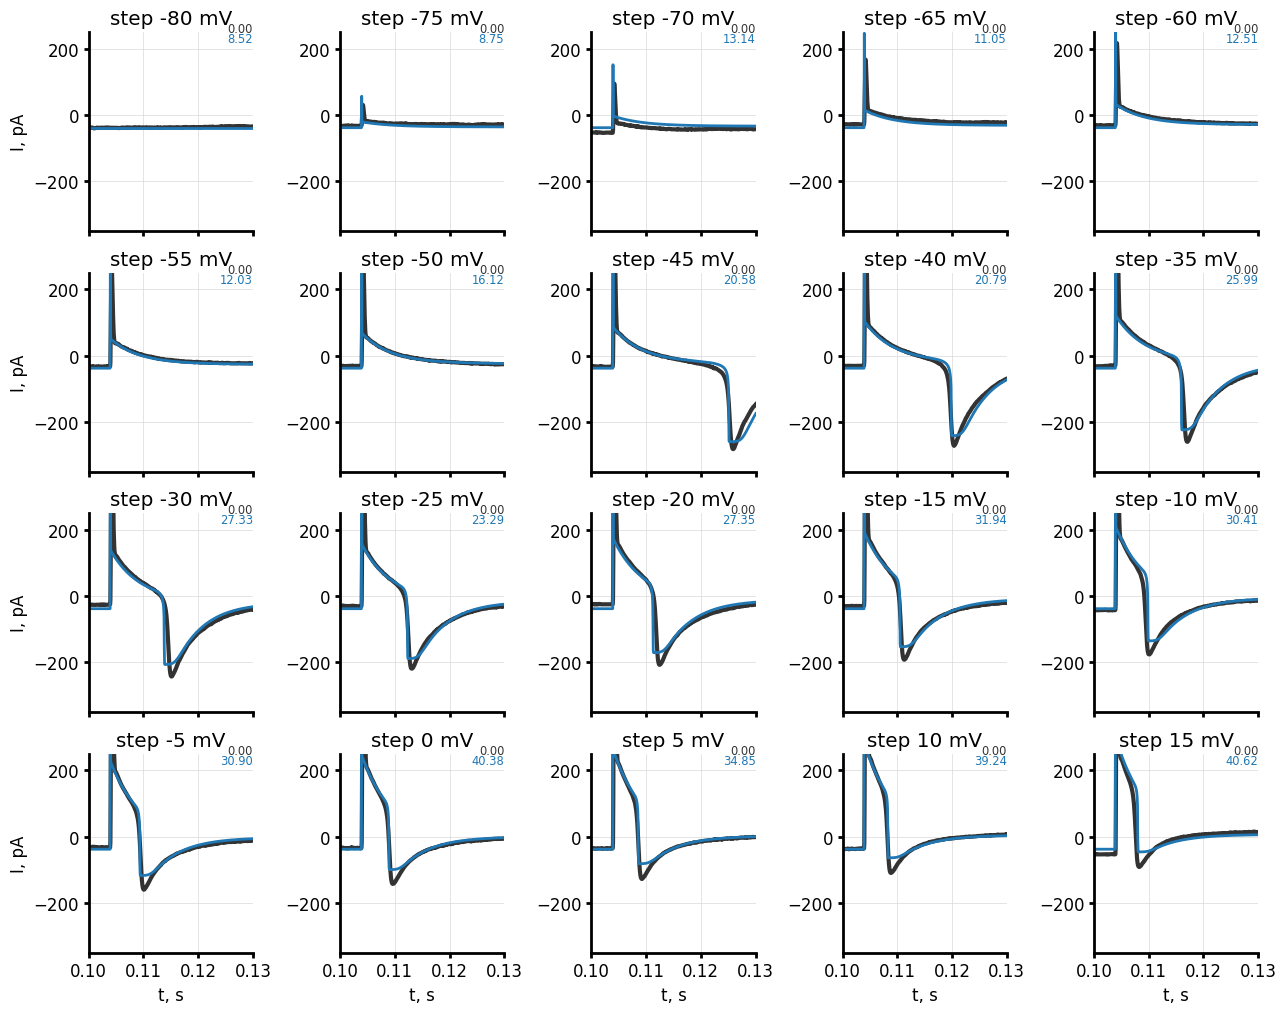

In [16]:
full_data = [real_datas['2020_12_19_0035'],I.I_out]

show_fig(full_data,  
         xlim = (0.10, 0.13),
         ylim=(-350, 250),
        )

In [17]:
sys.path.append('../src/python_func/')
from models import model1

In [23]:
v = np.arange(-100, 10)
datas = model1(v,C)
datas.keys()

dict_keys(['tau_m', 'tau_h', 'tau_j', 'm', 'h'])

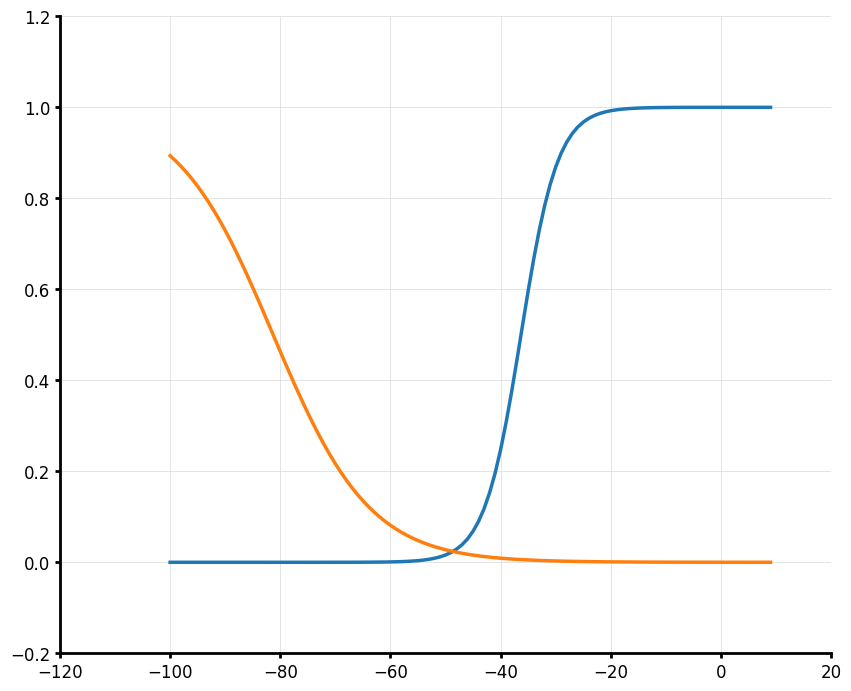

In [21]:
plt.plot(v, datas['m'])
plt.plot(v, datas['h'])